In [22]:
library(glmnet)
library(sjPlot)

In [5]:
df_train = read.csv('../input/country-metrics/country_info_clean.csv')

df_train$num_learners = scale(df_train$num_learners)
df_train$happiness = scale(df_train$happiness)
df_train$gdp_bill = scale(df_train$gdp_bill)
df_train$population = scale(df_train$population)
df_train$per_capita = scale(df_train$per_capita)

In [6]:
y = df_train$auc_score
x = data.matrix(df_train[, c('num_learners', 'happiness', 'gdp_bill', 'population', 'per_capita')])

# Feature Selection Using LASSO Regression

1. Determine best lambda using cross-validation.

In [7]:
cv_model = cv.glmnet(x, y, alpha = 1)
best_lambda = cv_model$lambda.min

[1] 0.008001284

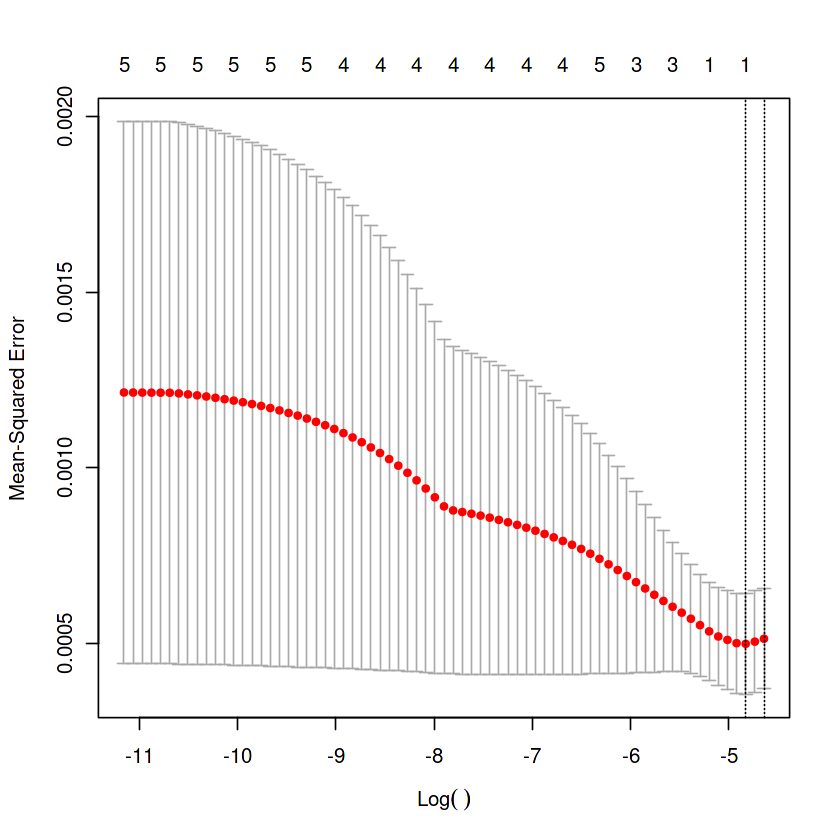

In [8]:
plot(cv_model)
best_lambda

2. Determine the best set of features using the best lambda.

In [9]:
best_model = glmnet(x, y, alpha = 1, lambda = best_lambda)

In [10]:
coef(best_model)

6 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  0.971076119
num_learners .          
happiness    0.001646486
gdp_bill     .          
population   .          
per_capita   .          

3. Compute the training data's R-squared

In [12]:
y_predicted = predict(best_model, s = best_lambda, newx = x)
sst = sum((y - mean(y))^2)
sse = sum((y_predicted - y)^2)
rsq = 1 - sse/sst
rsq

[1] 0.05794238

# Feature Selection Using Stepwise Forward Selection

1. Define base (intercept-only) model and full model with all predictors.

In [16]:
base.mod = lm(auc_score ~ 1 , data = df_train)  

all.mod = lm(auc_score ~ num_learners + happiness + gdp_bill + population + per_capita, data = df_train)

2. Perform step-wise algorithm
* direction = 'both': both forward and backward stepwise
* direction = 'forward': forward stepwise
* direction = 'backward': backward stepwise

In [27]:
stepMod = step(base.mod, scope = list(lower = base.mod, upper = all.mod), direction = "forward", trace = 0, steps = 1000)

3. Get the short-list of selected features.

In [30]:
shortlist = names(unlist(stepMod[[1]])) 
shortlist = shortlist[!shortlist %in% "(Intercept)"] # remove intercept
shortlist

[1] "happiness"  "population"

4. Fit a linear model using only the selected features to determine R-squared and coefficients.

In [24]:
lm_auc = lm(auc_score ~ happiness + population, data = df_train)
summary(lm_auc)


Call:
lm(formula = auc_score ~ happiness + population, data = df_train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.078404 -0.005569  0.003967  0.012044  0.026034 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.971076   0.002148 451.996  < 2e-16 ***
happiness   0.011555   0.002242   5.154 1.87e-06 ***
population  0.007016   0.002242   3.130  0.00246 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01934 on 78 degrees of freedom
Multiple R-squared:  0.2772,	Adjusted R-squared:  0.2587 
F-statistic: 14.96 on 2 and 78 DF,  p-value: 3.169e-06
